# Experiment of Attention based Network in predicting the price movements of SP500

In [1]:
import pickle
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
# import quandl
import itertools
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import collections
from sklearn.manifold import Isomap,MDS
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import sklearn
import statsmodels
yf.pdr_override()
import scipy.stats as scs
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import classification,confusion_matrix,matthews_corrcoef,accuracy_score,classification_report
from models.ffn_classifier import FFNClassifier
import scipy.stats as stats
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Price Data Preparation

In [2]:
def reset_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

In [3]:
lmap=lambda fun,it:list(map(lambda x:fun(x),it))

In [4]:
securities = pdr.get_data_yahoo(["SPY"], start="2005-01-01", end="2018-05-30")

[*********************100%***********************]  1 of 1 downloaded


In [5]:
class_number=2

In [6]:
data=securities['Adj Close'].fillna(method='ffill')
diff=(data.shift(-1)/data-1).fillna(0)
real_diff=data.shift(-1)-data.fillna(0)
labels=pd.qcut(diff,q=class_number,labels=range(class_number)).astype(int)

/home/ubuntu/mnt/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


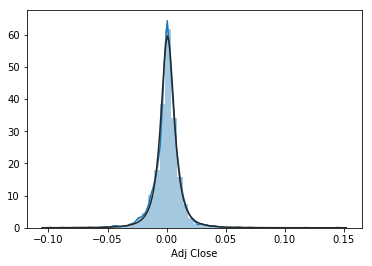

In [7]:
sns.distplot(diff,fit=stats.t)

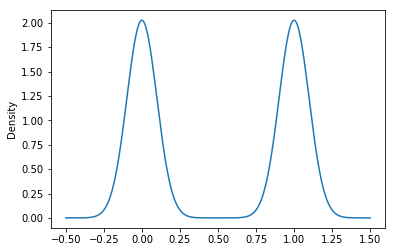

In [8]:
labels.plot(kind='kde')

## Define Test Function

In [64]:
def test(x,y,model,test_size=15,train_size=128,epoch=100, writer=None):
    train_loss=[]
    train_acc=[]
    train_mcc=[]
    dev_loss=[]
    dev_acc=[]
    dev_mcc=[]
    best_attns=None
    best_result=None
    best_score=0
    global_step=0
    best_result_epoch=0
    for e in range(epoch):
        pointer=0
        chunk_train_loss=0
        chunk_train_acc=0
        chunk_train_mcc=0
        train_count=0
        chunk_test_loss=0
        chunk_test_acc=0
        chunk_test_mcc=0
        test_count=0
        test_yhat=[]
        y_true=[]
        epoch_attns=[]
        while pointer<len(x):
            train_x=x[pointer:pointer+train_size]
            train_y=y[pointer:pointer+train_size]
            train_length=len(train_x)
            b_pointer=0
            while b_pointer<train_length:
                random_batch_size=np.random.randint(low=32,high=128)
                batch_x=train_x[b_pointer:b_pointer+random_batch_size]
                batch_y=train_y[b_pointer:b_pointer+random_batch_size]
                loss,acc,mcc,_,attn=model.train(X=batch_x,y=batch_y)
                epoch_attns.extend(attn)
                chunk_train_loss+=loss
                chunk_train_acc+=acc
                chunk_train_mcc+=mcc
                print('train loss',loss,'train acc',acc,'train mcc',mcc,'epoch:',e,'iter:',pointer)
                if writer:
                    writer.add_scalar(tag='train loss', scalar_value=loss, global_step=global_step)
                    writer.add_scalar(tag='train acc', scalar_value=acc, global_step=global_step)
                    writer.add_scalar(tag='train mcc', scalar_value=mcc, global_step=global_step)
                b_pointer+=len(batch_x)
                pointer+=len(batch_x)
                global_step+=1
                train_count+=1
            if pointer>=len(x):
                break
            test_x=x[pointer:pointer+test_size]
            test_y=y[pointer:pointer+test_size]
            loss,acc,mcc,y_hat,attn=model.test(X=test_x,y=test_y)
            epoch_attns.extend(attn)
            test_yhat.append(y_hat)
            y_true.append(test_y)
            print('test loss',loss,'test acc',acc,'test mcc',mcc,'epoch:',e,'iter:',pointer)
            chunk_test_loss+=loss
            chunk_test_acc+=acc
            chunk_test_mcc+=mcc
            test_count+=1
            pointer+=len(test_x)
        model.reset_model()
        chunk_train_loss=chunk_train_loss/train_count
        chunk_train_acc=chunk_train_acc/train_count
        chunk_train_mcc=chunk_train_mcc/train_count
        
        train_loss.append(chunk_train_loss)
        train_acc.append(chunk_train_acc)
        train_mcc.append(chunk_train_mcc)
        
        test_yhat=np.concatenate(test_yhat)
        y_true=np.concatenate(y_true)
        chunk_test_loss=chunk_test_loss/test_count
        chunk_test_acc=accuracy_score(y_pred=test_yhat,y_true=y_true)
        chunk_test_mcc=matthews_corrcoef(y_pred=test_yhat,y_true=y_true)
        
        if chunk_test_mcc+chunk_test_acc>best_score:
            best_result=test_yhat.copy()
            best_score=chunk_test_mcc+chunk_test_acc
            best_result_epoch=e
            best_attns=epoch_attns
            
        
        
        dev_loss.append(chunk_test_loss)
        dev_acc.append(chunk_test_acc)
        dev_mcc.append(chunk_test_mcc)
        if writer:
            writer.add_scalar(tag='dev loss', scalar_value=chunk_test_loss, global_step=global_step)
            writer.add_scalar(tag='dev acc', scalar_value=chunk_test_acc, global_step=global_step)
            writer.add_scalar(tag='dev mcc', scalar_value=chunk_test_mcc, global_step=global_step)
        print('best_result_epoch',best_result_epoch)
    return np.array(train_loss),np.array(train_acc),np.array(train_mcc),np.array(dev_loss),np.array(dev_acc), np.array(dev_mcc), best_result,y_true.flatten(), np.array(best_attns)

In [10]:
def trade(a,price_diff,initial_price,test_size=15,train_size=128):
    pointer=0
    test_r=initial_price
    bnh_r=initial_price
    while pointer<len(x):
        pointer+=train_size
        if pointer>=len(x):
            break
        test_a=a[pointer:pointer+test_size]
        test_a=test_a*2-1
        test_p=price_diff[pointer:pointer+test_size]
        test_r+=(test_p*test_a).sum()
        bnh_r+=test_p.sum()
        pointer+=len(test_p)
    return test_r,bnh_r,test_r/initial_price,bnh_r/initial_price

In [58]:
# -*- coding:utf-8 -*-
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, matthews_corrcoef
import numpy as np
import os

lmap = lambda func, it: list(map(lambda x: func(x), it))


class Attention(nn.Module):
    def __init__(self, d_x, d_h, temporal=False, dp=0.5):
        super(Attention, self).__init__()
        self.temporal = temporal
        self.w = nn.Linear(d_x, d_h)
        self.dropout = nn.Dropout(p=dp)
        if self.temporal:
            self.u = nn.Linear(d_h, d_h, bias=False)
    
    def forward(self, x_t, hidden=None):
        if self.temporal and hidden is not None:
            v_t = self.dropout(F.relu(self.w(x_t) + self.u(hidden)))
        else:
            v_t = self.dropout(F.relu(self.w(x_t)))
        e_t = torch.matmul(v_t, torch.transpose(v_t, 2, 1))
        e_t = e_t.sum(dim=1, keepdim=True)
        e_t = F.softmax(e_t, dim=-1)
        a_t = torch.matmul(e_t, x_t)
        return a_t, e_t


class AttnRNN(nn.Module):
    def __init__(self, d_x, d_h, d_o, rnn_layers=2, ffn_layers=5, cell=nn.GRU, temporal=False, dp=0.5):
        super(AttnRNN, self).__init__()
        self.temporal = temporal
        self.dropout = nn.Dropout(p=dp)
        self.f_in = nn.Linear(in_features=d_x,out_features=d_h)
        self.attn = Attention(d_h, d_h, temporal=self.temporal)
        self.rnn = cell(input_size=d_h, hidden_size=d_h, num_layers=rnn_layers, batch_first=True, dropout=dp)
        self.hls = nn.ModuleList([nn.Linear(in_features=d_h, out_features=d_h) for _ in range(ffn_layers)])
        self.lms = nn.ModuleList([nn.LayerNorm(d_h) for _ in range(ffn_layers)])
        self.f_out = nn.Linear(in_features=d_h, out_features=d_o)
        for p in self.attn.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, x_t, hidden):
        x_t=self.f_in(x_t)
        if self.temporal and hidden is not None:
            if type(hidden) == tuple:
                h_t_1 = hidden[0]
            elif type(hidden) == torch.Tensor:
                h_t_1 = hidden
            else:
                raise RuntimeError("h_t_1 is None")
            a_t, e_t = self.attn(x_t, h_t_1[-1, None, :, :])
        else:
            a_t, e_t = self.attn(x_t, hidden=None)
        o_t, hidden = self.rnn(a_t, hidden)
        o_t_initial = o_t
        for hl, lm in zip(self.hls, self.lms):
            o_t = self.dropout(lm(F.leaky_relu(hl(o_t))))
        o_t = self.f_out(o_t + o_t_initial)
        return o_t, hidden, e_t


class AttnFFN(nn.Module):
    def __init__(self, d_x, d_h, d_o, ffn_layers=5, dp=0.5):
        super(AttnFFN, self).__init__()
        self.f_in = nn.Linear(in_features=d_x,out_features=d_h)
        self.attn = Attention(d_h, d_h, temporal=False)
        self.hiddens = nn.ModuleList([nn.Linear(in_features=d_h, out_features=d_h) for _ in range(ffn_layers)])
        self.lms = nn.ModuleList([nn.LayerNorm(d_h) for _ in range(ffn_layers)])
        self.f_out = nn.Linear(in_features=d_h, out_features=d_o)
        self.dropout = nn.Dropout(p=dp)
    
    def forward(self, x_t, hidden=None):
        # use hidden here for compatible
        o_t=self.f_in(x_t)
        o_t, e_t = self.attn(o_t)
        o_t_initial = o_t
        for hl, lm in zip(self.hiddens, self.lms):
            o_t = self.dropout(lm(F.leaky_relu(hl(o_t))))
        o_t = self.f_out(o_t + o_t_initial)
        return o_t, hidden, e_t


class AttentionClassifier(object):
    def __init__(self, d_x, d_h, d_o, attn_model, lr=1e-3):
        super(AttentionClassifier, self).__init__()
        self.d_h = d_h
        self.attn_model = attn_model
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(list(self.attn_model.parameters()), lr=lr)
        self.tmp_hidden = None
        for p in self.attn_model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def train(self, X, y):
        self.attn_model.train(True)
        self.attn_model.attn.train(True)
        self.optimizer.zero_grad()
        loss = 0
        y_hats = []
        attns = []
        for i, x in enumerate(X):
            y_hat_t, self.tmp_hidden, e_t = self.attn_model(
                torch.tensor(x[None, :, :], dtype=torch.float32),
                self.tmp_hidden
            )
            y_hat_t = y_hat_t.squeeze(0)
            y_true_t = torch.tensor([y[i]], dtype=torch.long)
            loss += self.loss_func(y_hat_t, y_true_t)
            topv, topi = y_hat_t.topk(1)
            y_hat = topi.detach().item()
            y_hats.append(y_hat)
            attns.append(e_t.view(-1).detach().numpy())
        loss = loss / len(X)
        loss.backward()
        clip_grad_norm_(self.attn_model.parameters(), 1)
        self.optimizer.step()
        y_hat = np.array(y_hats)
        if type(self.tmp_hidden) == tuple:
            self.tmp_hidden = tuple([h.detach() for h in self.tmp_hidden])
        elif type(self.tmp_hidden) == torch.Tensor:
            self.tmp_hidden = self.tmp_hidden.detach()
        else:
            self.tmp_hidden = None
        acc = accuracy_score(y_true=y.flatten(), y_pred=y_hat)
        mcc = matthews_corrcoef(y_true=y.flatten(), y_pred=y_hat)
        return loss.item(), acc, mcc, y_hat, attns
    
    def test(self, X, y):
        self.attn_model.eval()
        self.attn_model.attn.eval()
        with torch.no_grad():
            loss = 0
            y_hats = []
            attns = []
            for i, x in enumerate(X):
                y_hat_t, self.tmp_hidden, e_t = self.attn_model(torch.tensor(x[None, :, :], dtype=torch.float32), self.tmp_hidden)
                y_hat_t = y_hat_t.squeeze(0)
                y_t = torch.tensor([y[i]], dtype=torch.long)
                loss += self.loss_func(y_hat_t, y_t)
                topv, topi = y_hat_t.topk(1)
                y_hat = topi.detach().item()
                y_hats.append(y_hat)
                attns.append(e_t.view(-1).detach().numpy())
            loss = loss / len(X)
            y_hat = np.array(y_hats)
            acc = accuracy_score(y_true=y.flatten(), y_pred=y_hat)
            mcc = matthews_corrcoef(y_true=y.flatten(), y_pred=y_hat)
            return loss.item(), acc, mcc, y_hat, attns
    
    def inference(self, X):
        self.attn_model.eval()
        self.attn_model.attn.eval()
        with torch.no_grad():
            y_hats = []
            attns = []
            for i, x in enumerate(X):
                y_hat_t, self.tmp_hidden, e_t = self.attn_model(torch.tensor(x[None, :, :], dtype=torch.float32), self.tmp_hidden)
                y_hat_t = y_hat_t.squeeze(0)
                topv, topi = y_hat_t.topk(1)
                y_hat = topi.detach().item()
                y_hats.append(y_hat)
                attns.append(e_t.view(-1).detach().numpy())
            y_hat = np.array(y_hats)
            return y_hat, attns
    
    def reset_model(self):
        self.tmp_hidden = None
    
    def load_model(self, model_path='./AttnModel'):
        self.attn_model = torch.load(model_path + '/model.pkl')
    
    def save_model(self, model_path='./AttnModel'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        torch.save(self.attn_model, model_path + '/model.pkl')


### Experiment of pre-trained elmo encoded title, (mean with date)

In [65]:
reset_seed(1)

Each news title is a vector produced by mean of Elmo representation

In [13]:
date_index=np.load('data/title_elmo_index.npy')
content=np.load('data/title_elmo.npy')
content=pd.DataFrame(content,index=date_index)
content=content.join(labels).fillna(method='bfill').dropna()['2010-06':]

In [14]:
index_=sorted(list(content.groupby(content.index).groups.keys()))

x=[]
for i in range(len(index_)):
    x_=content.loc[index_[i]].values
    if len(x_.shape)<2:
        x.append(x_[None,:content.shape[-1]-1])
    else:
        x.append(x_[:,:content.shape[-1]-1])

In [15]:
y=content.groupby(content.index)[content.columns[-1]].mean().values.flatten()

In [18]:
del content
del date_index

In [66]:
ffn_model=AttnFFN(d_x=x[0].shape[-1],d_h=300,d_o=class_number,ffn_layers=5)

In [67]:
rnn_model=AttnRNN(d_x=x[0].shape[-1],d_h=300,d_o=class_number,cell=nn.GRU,rnn_layers=2,ffn_layers=5,temporal=False)

In [68]:
clf=AttentionClassifier(attn_model=ffn_model,d_x=x[0].shape[-1],d_h=300,d_o=class_number)

In [69]:
train_loss,train_acc,train_mcc,dev_loss,dev_acc,dev_mcc,best_result,y_true,best_attns=test(model=clf,x=x,y=y,train_size=150,test_size=15,epoch=1)

train loss 1.6390303373336792 train acc 0.4927536231884058 train mcc 0.05221015967643629 epoch: 0 iter: 0
train loss 2.5550293922424316 train acc 0.4772727272727273 train mcc -0.009929257812241655 epoch: 0 iter: 69
train loss 1.9877315759658813 train acc 0.5135135135135135 train mcc 0.22038926600773587 epoch: 0 iter: 113


/home/ubuntu/mnt/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


test loss 2.525205135345459 test acc 0.3333333333333333 test mcc 0.0 epoch: 0 iter: 150
train loss 1.1163990497589111 train acc 0.6341463414634146 train mcc 0.22382147335384786 epoch: 0 iter: 165
train loss 1.7476894855499268 train acc 0.5233644859813084 train mcc 0.0028733141061374375 epoch: 0 iter: 206
train loss 1.7025482654571533 train acc 0.0 train mcc 0.0 epoch: 0 iter: 313
test loss 0.8474798798561096 test acc 0.4666666666666667 test mcc -0.026207120918047958 epoch: 0 iter: 315
train loss 1.1416571140289307 train acc 0.5495495495495496 train mcc 0.10301070542879115 epoch: 0 iter: 330
train loss 2.3887083530426025 train acc 0.41025641025641024 train mcc -0.10857142857142857 epoch: 0 iter: 441
test loss 0.8729877471923828 test acc 0.6 test mcc 0.16666666666666666 epoch: 0 iter: 480
train loss 1.3628945350646973 train acc 0.6041666666666666 train mcc 0.16972502573910517 epoch: 0 iter: 495
train loss 1.408629298210144 train acc 0.45454545454545453 train mcc -0.11654135338345864 epoc

In [72]:
clf=AttentionClassifier(attn_model=rnn_model,d_x=x[0].shape[-1],d_h=300,d_o=class_number)

In [73]:
train_loss,train_acc,train_mcc,dev_loss,dev_acc,dev_mcc,best_result,y_true,best_attns=test(model=clf,x=x,y=y,train_size=150,test_size=15,epoch=1)

train loss 1.4858139753341675 train acc 0.4854368932038835 train mcc -0.009114591746350924 epoch: 0 iter: 0
train loss 0.9853986501693726 train acc 0.5714285714285714 train mcc 0.1877669040497027 epoch: 0 iter: 103
train loss 2.1266348361968994 train acc 0.4166666666666667 train mcc -0.1690308509457033 epoch: 0 iter: 138


/home/ubuntu/mnt/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


test loss 1.4121356010437012 test acc 0.3333333333333333 test mcc 0.0 epoch: 0 iter: 150
train loss 1.3618730306625366 train acc 0.49056603773584906 train mcc -0.04227477114349428 epoch: 0 iter: 165
train loss 1.6150058507919312 train acc 0.4567901234567901 train mcc -0.09182622582426504 epoch: 0 iter: 218
train loss 1.9375121593475342 train acc 0.3125 train mcc -0.28941438070815306 epoch: 0 iter: 299
test loss 2.0551984310150146 test acc 0.4666666666666667 test mcc 0.0 epoch: 0 iter: 315
train loss 1.2440690994262695 train acc 0.45714285714285713 train mcc -0.0993399267798783 epoch: 0 iter: 330
train loss 1.3825035095214844 train acc 0.5 train mcc 0.010101010101010102 epoch: 0 iter: 365
train loss 1.539506435394287 train acc 0.6 train mcc 0.2004459314343183 epoch: 0 iter: 465
test loss 0.8569240570068359 test acc 0.6 test mcc 0.0 epoch: 0 iter: 480
train loss 1.4350095987319946 train acc 0.5066666666666667 train mcc -0.020145574100634507 epoch: 0 iter: 495
train loss 1.340721249580383